In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
data = pd.read_csv("TSLA.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


# Feature Engineering

### Relative Strength Index

In [3]:
# Window length for moving average
window_length = 14

close = data['Adj Close']
# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

In [4]:
# Calculate the RSI based on RMA/SMMA/MMA
# Reminder: Try to provide at least `window_length * 4` data points!
# Note: This should most closely match TradingView.
alpha = 1 / window_length
roll_up = up.ewm(alpha=alpha).mean()
roll_down = down.ewm(alpha=alpha).mean()
rs = roll_up / roll_down
rsi_rma = 100.0 - (100.0 / (1.0 + rs))

### Stochastic Oscillator and Williams %R

In [7]:
high_14 = data['High'].rolling(14).max()
low_14 = data['Low'].rolling(14).min()
K = (data['Close'] - high_14)*100/(high_14 - low_14)
D = K.rolling(3).mean()
R = (high_14-data['Close'])*(-100)/(high_14 - low_14)

### Moving Average Convergence Divergence (MACD)

In [8]:
exp1 = close.ewm(span=12, adjust=False).mean()
exp2 = close.ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
exp3 = macd.ewm(span=9, adjust=False).mean()

### Price Rate of Change

In [11]:
# Computing 5-day rate of change
N = data['Close'].diff(5)
D = data['Close'].shift(5)
ROC = pd.Series(N/D,name='ROC')

### On Balance Volume

In [12]:
OBV = []
OBV.append(0)
for i in range(1, len(data.Close)):
    if data.Close[i] > data.Close[i-1]: #If the closing price is above the prior close price 
          OBV.append(OBV[-1] + data.Volume[i]) #then: Current OBV = Previous OBV + Current Volume
    elif data.Close[i] < data.Close[i-1]:
          OBV.append( OBV[-1] - data.Volume[i])
    else:
          OBV.append(OBV[-1])

In [13]:
#Store the OBV and OBV EMA into new columns
OBV = pd.Series(OBV, name='OBV')
OBV_EMA = OBV.ewm(com=20).mean()
# data['OBV_EMA'] = data['OBV'].ewm(com=20).mean()
#Show the data
OBV

0                0
1        -85935500
2       -127029500
3       -152728500
4       -187063000
           ...    
2974    5656694500
2975    5633512900
2976    5610732500
2977    5565354600
2978    5590939900
Name: OBV, Length: 2979, dtype: int64

### Rise and fall of stock price

In [17]:
rise_fall = np.where(data['Close']-data['Close'].shift(1)>0, 1, 0)

### Features and train-test split

In [18]:
features = pd.DataFrame(data={"RSI":rsi_rma, "SO":D, "WR":R, "MACD":macd, "ROC":ROC, "OBV":OBV_EMA})
target_df = pd.DataFrame(data={'3-day':data['Close'].shift(-3), '5-day':data['Close'].shift(-5), '7-day':data['Close'].shift(-7), '10-day':data['Close'].shift(-10), 'Change':rise_fall}).set_index(data['Date'])

In [19]:
# Remove top 14 and last 10 rows to avoid NaN values
features = features.iloc[14:-10,:]
target_df = target_df.iloc[14:-10,:]
print('Features dataframe shape:', features.shape)
print('Target dataframe shape:', target_df.shape)

Features dataframe shape: (2955, 6)
Target dataframe shape: (2955, 5)


In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error,mean_absolute_error

In [115]:
X_train, X_test, y_train, y_test = train_test_split(features, target_df['5-day'].to_numpy(), test_size=0.3)

In [116]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(features):
        X_train, X_test = features[:len(train_index)], features[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_df["5-day"][:len(train_index)].values.ravel(), target_df["5-day"][len(train_index): (len(train_index)+len(test_index))].values.ravel()

# Regression

### [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [128]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [129]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [ -2.67199775 240.11478368   0.30452569  13.55806347   8.40532718
   8.338316  ]
Mean squared error: 10035.32
Mean Absolute Percentage error: 8.38
Mean Absolute error: 74.17
Coefficient of determination: 0.67


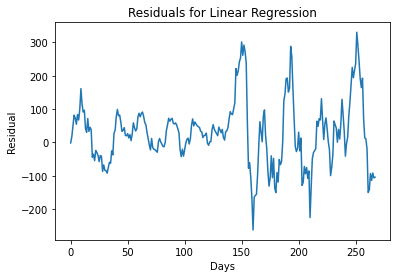

Mean of residuals: 28.06224944026181
Std of residuals: 96.1656240297873


In [130]:
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Linear Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

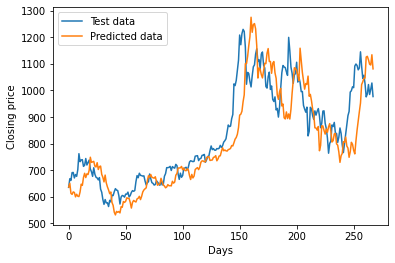

In [131]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

Coefficients: 
 [ -2.67463614 239.43360674   0.30976701  13.69910346   8.38683265
   8.69651461]
Mean squared error: 10081.80
Mean Absolute Percentage error: 8.41
Mean Absolute error: 74.40
Coefficient of determination: 0.67


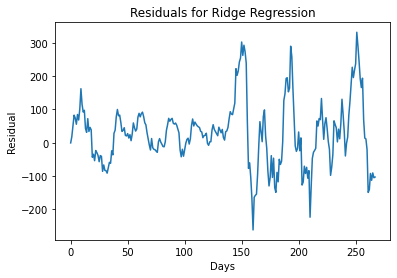

Mean of residuals: 29.09132430303097
Std of residuals: 96.10147786285347


In [132]:
ridge_reg = linear_model.Ridge(alpha=.5)
ridge_reg.fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)
print("Coefficients: \n", ridge_reg.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Ridge Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

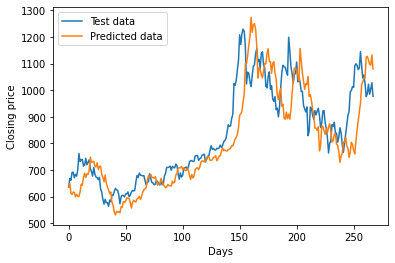

In [133]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### Suppor Vector Machines

Mean squared error: 558146.59
Mean Absolute Percentage error: 86.10
Mean Absolute error: 723.88
Coefficient of determination: -17.11


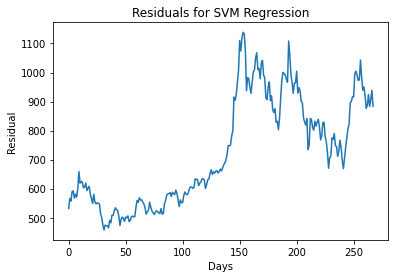

Mean of residuals: 723.8818988229139
Std of residuals: 184.77443271748953


In [135]:
from sklearn import svm
svm_reg = svm.SVR()
svm_reg.fit(X_train, y_train)
y_pred = svm_reg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for SVM Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

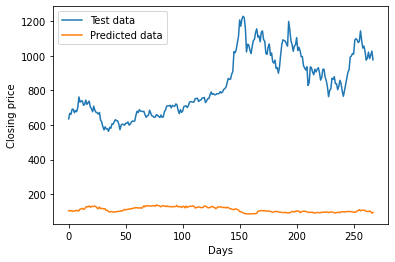

In [136]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### [Bayesian Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge)
The priors over α and λ are chosen to be gamma distributions, the conjugate prior for the precision of the Gaussian. The resulting model is called Bayesian Ridge Regression, and is similar to the classical Ridge.

Mean squared error: 10038.42
Mean Absolute Percentage error: 8.38
Mean Absolute error: 74.19
Coefficient of determination: 0.67


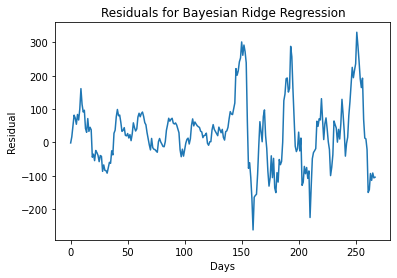

Mean of residuals: 28.132754804712437
Std of residuals: 96.16117530855335


In [137]:
bayesian_reg = linear_model.BayesianRidge()
bayesian_reg.fit(X_train, y_train)
y_pred = bayesian_reg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Bayesian Ridge Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

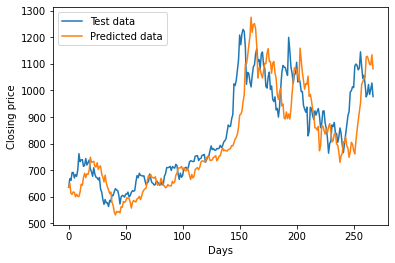

In [138]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### [ElasticNet Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)
Linear regression with combined L1 and L2 priors as regularizer.

Mean squared error: 199155.28
Mean Absolute Percentage error: 51.29
Mean Absolute error: 428.60
Coefficient of determination: -5.46


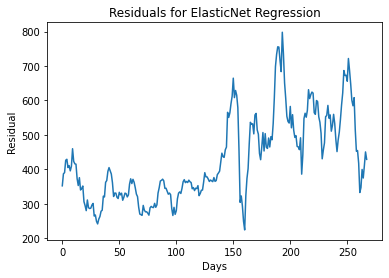

Mean of residuals: 428.6040134371133
Std of residuals: 124.31364063488103


In [139]:
ElasticNet_reg = linear_model.ElasticNet()
ElasticNet_reg.fit(X_train, y_train)
y_pred = ElasticNet_reg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for ElasticNet Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

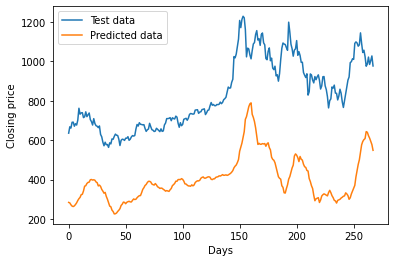

In [140]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### [Generalized Linear Regression Models](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-regression)

#### [Poisson Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html#sklearn.linear_model.PoissonRegressor)
Generalized Linear Model with a Poisson distribution.

Mean squared error: 18849.04
Mean Absolute Percentage error: 11.91
Mean Absolute error: 102.23
Coefficient of determination: 0.39


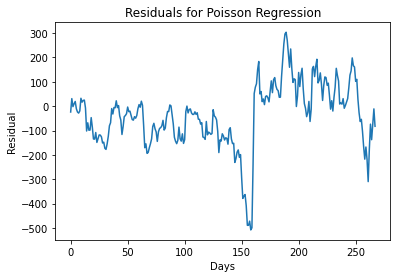

Mean of residuals: -38.76687800293341
Std of residuals: 131.7048647339366


In [141]:
poisson_reg = linear_model.PoissonRegressor()
poisson_reg.fit(X_train, y_train)
y_pred = poisson_reg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Poisson Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

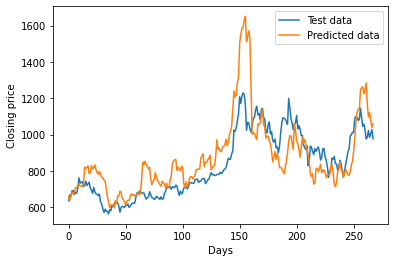

In [142]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

#### [Gamma Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.GammaRegressor.html#sklearn.linear_model.GammaRegressor)
Generalized Linear Model with a Gamma distribution. This regressor uses the ‘log’ link function.

Mean squared error: 264994.52
Mean Absolute Percentage error: 61.17
Mean Absolute error: 498.13
Coefficient of determination: -7.60


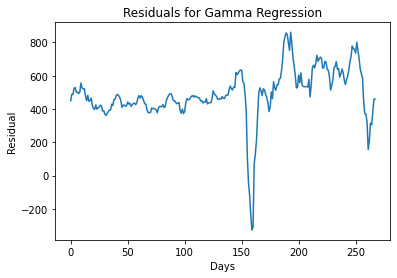

Mean of residuals: 490.3943445325517
Std of residuals: 156.55001529366953


In [143]:
gamma_reg = linear_model.GammaRegressor()
gamma_reg.fit(X_train, y_train)
y_pred = gamma_reg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Gamma Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

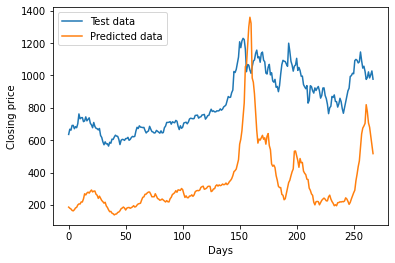

In [144]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### Random Forest Regressor

Mean squared error: 36445.04
Mean Absolute Percentage error: 15.59
Mean Absolute error: 146.62
Coefficient of determination: -0.18


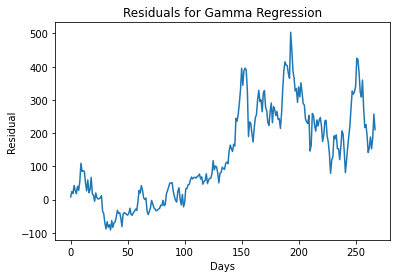

Mean of residuals: 130.7604905300744
Std of residuals: 139.09252916371977


In [156]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor()
rfg.fit(X_train, y_train)
y_pred = rfg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Gamma Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

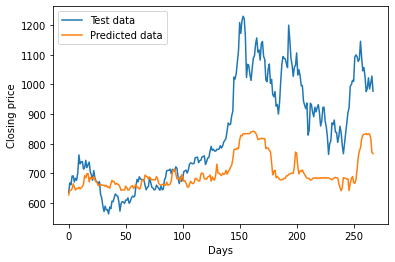

In [157]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### Xgboost regressor

[04:18:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 48097.42
Mean Absolute Percentage error: 17.43
Mean Absolute error: 165.17
Coefficient of determination: -0.56


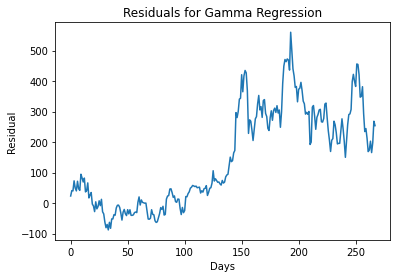

Mean of residuals: 149.3108536291103
Std of residuals: 160.63526661064358


In [153]:
import xgboost as xg
xgb_r = xg.XGBRegressor(n_estimators=50,max_depth=25,seed = 123)
xgb_r.fit(X_train, y_train)
y_pred = xgb_r.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Gamma Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

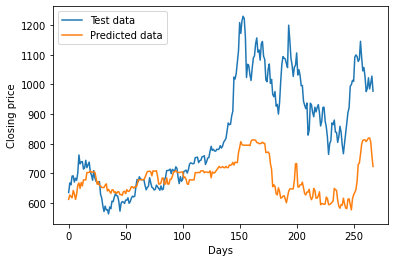

In [154]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### LSTM Model

In [86]:
import matplotlib.dates as mandates
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow import keras 
import tensorflow as tf

In [87]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(features):
        X_train, X_test = features[:len(train_index)], features[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_df["5-day"][:len(train_index)].values.ravel(), target_df["5-day"][len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [88]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_train.shape

(2687, 6, 1)

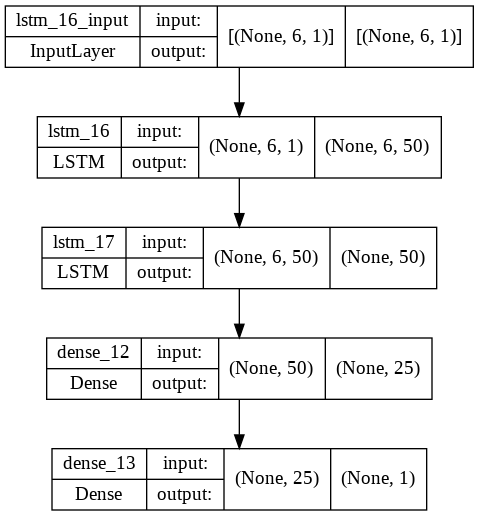

In [107]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1),activation='relu'))
model.add(LSTM(units=50,activation='relu'))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=60, batch_size=64, verbose=1)

In [109]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
y_pred = model.predict(X_test)
y_test = y_test.reshape(y_pred.shape)

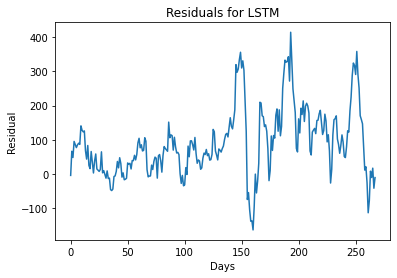

Mean of residuals: 91.17618046781715
Std of residuals: 99.16321446609248


In [110]:
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for LSTM")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

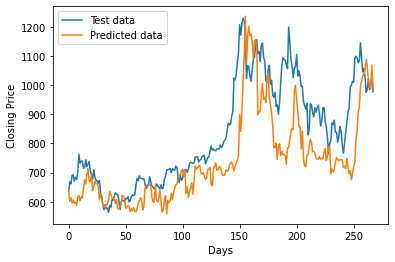

In [111]:
plt.plot([i for i in range(len(y_test))], y_test)
plt.plot([i for i in range(len(y_test))], y_pred)
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend(['Test data', 'Predicted data'])
plt.show()

In [112]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 18146.44
Coefficient of determination: 0.41


# Classification

In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
X_train, X_test, y_train, y_test = train_test_split(features, target_df['Change'].to_numpy(), test_size=0.3)

### [Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [59]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [60]:
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Confusion matrix:
[[257 176]
 [148 306]]
Accuracy score: 0.6347237880496054
Recall score: 0.6740088105726872
F1 score: 0.6538461538461537


### [Stochastic Gradient Descent Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

In [61]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [62]:
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Confusion matrix:
[[294 139]
 [192 262]]
Accuracy score: 0.6268320180383314
Recall score: 0.5770925110132159
F1 score: 0.6128654970760233


### [Linear Discriminant Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)

In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis().fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy score: 0.6358511837655016
Recall score: 0.7048458149779736
F1 score: 0.6645898234683282


### [KNN Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [64]:
from sklearn import neighbors
n_neighbors = 15
for weights in ["uniform", "distance"]:
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("For weights =", weights)
    print("Accuracy score:", accuracy_score(y_test, y_pred))
    print("Recall score:",recall_score(y_test, y_pred))
    print("F1 score:", f1_score(y_test, y_pred))
    print('-'*15)

For weights = uniform
Accuracy score: 0.6099210822998873
Recall score: 0.6960352422907489
F1 score: 0.6462167689161554
---------------
For weights = distance
Accuracy score: 0.6144306651634723
Recall score: 0.698237885462555
F1 score: 0.6495901639344263
---------------


### [Gaussian Process Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier)

In [65]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [66]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X_train, y_train)

In [67]:
y_pred = gpc.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy score: 0.6234498308906427
Recall score: 0.6872246696035242
F1 score: 0.651356993736952


### [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [68]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy score: 0.5975197294250282
Recall score: 0.6299559471365639
F1 score: 0.6157158234660925


### [Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html)
The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

#### [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [71]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy score: 0.6223224351747464
Recall score: 0.6167400881057269
F1 score: 0.6256983240223465


#### [Bagging Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier)

In [72]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
print("Using SVC as base estimator")
clf = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print('-'*15)
print("Using DecisionTreeClassifier as base estimator")
clf = BaggingClassifier(base_estimator=None, n_estimators=10, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Using SVC as base estimator
Accuracy score: 0.6437429537767756
Recall score: 0.7136563876651982
F1 score: 0.6721991701244814
---------------
Using DecisionTreeClassifier as base estimator
Accuracy score: 0.636978579481398
Recall score: 0.6321585903083701
F1 score: 0.640625


### [Multi-layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [73]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, learning_rate='adaptive', max_iter=10000).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy score: 0.6437429537767756
Recall score: 0.7070484581497798
F1 score: 0.6701461377870563


In [74]:
clf = MLPClassifier(activation='identity', solver='lbfgs',random_state=1, max_iter=10000).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy score: 0.6358511837655016
Recall score: 0.7048458149779736
F1 score: 0.6645898234683282


### Sentiment Analysis

In [166]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [177]:
# Read in the data
df = pd.read_csv('Stock News Dataset.csv', encoding = "ISO-8859-1")
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite
2,2000-01-05,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,...,South Melbourne (Australia),Necaxa (Mexico),Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil),Tony's pet project,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links
3,2000-01-06,1,Pilgrim knows how to progress,Thatcher facing ban,McIlroy calls for Irish fighting spirit,Leicester bin stadium blueprint,United braced for Mexican wave,"Auntie back in fashion, even if the dress look...",Shoaib appeal goes to the top,Hussain hurt by 'shambles' but lays blame on e...,...,Putin admits Yeltsin quit to give him a head s...,BBC worst hit as digital TV begins to bite,How much can you pay for...,Christmas glitches,"Upending a table, Chopping a line and Scoring ...","Scientific evidence 'unreliable', defence claims",Fusco wins judicial review in extradition case,Rebels thwart Russian advance,Blair orders shake-up of failing NHS,Lessons of law's hard heart
4,2000-01-07,1,Hitches and Horlocks,Beckham off but United survive,Breast cancer screening,Alan Parker,Guardian readers: are you all whingers?,Hollywood Beyond,Ashes and diamonds,Whingers - a formidable minority,...,Most everywhere: UDIs,Most wanted: Chloe lunettes,Return of the cane 'completely off the agenda',From Sleepy Hollow to Greeneland,Blunkett outlines vision for over 11s,"Embattled Dobson attacks 'play now, pay later'...",Doom and the Dome,What is the north-south divide?,Aitken released from jail,Gone aloft


In [191]:
traindf = data[data['Date'] < '20150101']
testdf = data[data['Date'] > '20141231']

In [192]:
# Removing punctuations
headlinesdf= traindf.iloc[:,2:27]
headlinesdf.replace(to_replace="[^a-zA-Z]", value=" ", regex=True, inplace=True)
headlinesdf.columns= [str(i) for i in range(25)]
headlinesdf.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,A hindrance to operations extracts from the...,Scorecard,Hughes instant hit buoys Blues,Jack gets his skates on at ice cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,Derby raise a glass to Strupar s debut double,Southgate strikes Leeds pay the penalty,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl s successor drawn into scandal,The difference between men and women,Sara Denver nurse turned solicitor,Diana s landmine crusade put Tories in a panic,Yeltsin s resignation caught opposition flat f...,Russian roulette,Sold out,Recovering a title
1,Scorecard,The best lake scene,Leader German sleaze inquiry,Cheerio boyo,The main recommendations,Has Cubie killed fees,Has Cubie killed fees,Has Cubie killed fees,Hopkins furious at Foster s lack of Hannibal...,Has Cubie killed fees,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man s extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn t know without the ...,Millennium bug fails to bite
2,Coventry caught on counter by Flo,United s rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,McGrath puts India out of their misery,Blair Witch bandwagon rolls on,...,South Melbourne Australia,Necaxa Mexico,Real Madrid Spain,Raja Casablanca Morocco,Corinthians Brazil,Tony s pet project,Al Nassr Saudi Arabia,Ideal Holmes show,Pinochet leaves hospital after tests,Useful links
3,Pilgrim knows how to progress,Thatcher facing ban,McIlroy calls for Irish fighting spirit,Leicester bin stadium blueprint,United braced for Mexican wave,Auntie back in fashion even if the dress look...,Shoaib appeal goes to the top,Hussain hurt by shambles but lays blame on e...,England s decade of disasters,Revenge is sweet for jubilant Cronje,...,Putin admits Yeltsin quit to give him a head s...,BBC worst hit as digital TV begins to bite,How much can you pay for,Christmas glitches,Upending a table Chopping a line and Scoring ...,Scientific evidence unreliable defence claims,Fusco wins judicial review in extradition case,Rebels thwart Russian advance,Blair orders shake up of failing NHS,Lessons of law s hard heart
4,Hitches and Horlocks,Beckham off but United survive,Breast cancer screening,Alan Parker,Guardian readers are you all whingers,Hollywood Beyond,Ashes and diamonds,Whingers a formidable minority,Alan Parker part two,Thuggery Toxins and Ties,...,Most everywhere UDIs,Most wanted Chloe lunettes,Return of the cane completely off the agenda,From Sleepy Hollow to Greeneland,Blunkett outlines vision for over s,Embattled Dobson attacks play now pay later ...,Doom and the Dome,What is the north south divide,Aitken released from jail,Gone aloft


In [193]:
headlines = []
for row in range(0,len(headlinesdf.index)):
    headlines.append(' '.join(str(x).lower() for x in headlinesdf.iloc[row,0:25]))
headlines[0]

'a  hindrance to operations   extracts from the leaked reports scorecard hughes  instant hit buoys blues jack gets his skates on at ice cold alex chaos as maracana builds up for united depleted leicester prevail as elliott spoils everton s party hungry spurs sense rich pickings gunners so wide of an easy target derby raise a glass to strupar s debut double southgate strikes  leeds pay the penalty hammers hand robson a youthful lesson saints party like it s      wear wolves have turned into lambs stump mike catches testy gough s taunt langer escapes to hit     flintoff injury piles on woe for england hunters threaten jospin with new battle of the somme kohl s successor drawn into scandal the difference between men and women sara denver  nurse turned solicitor diana s landmine crusade put tories in a panic yeltsin s resignation caught opposition flat footed russian roulette sold out recovering a title'

In [194]:
#tokenize the word data
vectorizer = CountVectorizer(ngram_range=(2,2))
train_data = vectorizer.fit_transform(headlines)

In [195]:
#initialise the base model
model = LogisticRegression()
model = model.fit(train_data, traindf["Label"])

In [196]:
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in testdf.iloc[row,2:27]))
test_data = vectorizer.transform(testheadlines)
predictions = model.predict(test_data)

In [197]:
pd.crosstab(testdf["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,159,27
1,27,165


In [198]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

print(classification_report(testdf["Label"], predictions))
print(accuracy_score(testdf["Label"], predictions))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       186
           1       0.86      0.86      0.86       192

    accuracy                           0.86       378
   macro avg       0.86      0.86      0.86       378
weighted avg       0.86      0.86      0.86       378

0.8571428571428571
